In [1]:
import os, sys, random, pandas as pd, numpy as np
from tqdm import tqdm
import torch


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
sys.path.append('../')


# load package requirments
from VGFM.utils import  generate_steps, parser, _valid_criterions
from VGFM.plots import plot_comparision
from VGFM.train import pretrain, train
from VGFM.models import  FNet, ODEFunc2
from VGFM.constants import DATA_DIR
from VGFM.exp import setup_exp
from VGFM.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint

### Defining parameters and loading dataset

In [2]:
import torch.optim as optim

dim=5
f_net = FNet(in_out_dim=dim, hidden_dim=128, n_hiddens=3, activation='leakyrelu')


import sys

# Simulate the command-line arguments
sys.argv = [
    'VGFM Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'dyngen_final',
    '--no-hold-one-out',
    '-ho', '-1',
    '-e1', '500',
    '-e2', '30',
    '-bs', '60',
    '-r', '0.03',
    '-rm', '5',
    '--no-norm_cost'
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


{'dataset': 'file', 'time_col': None, 'name': 'dyngen_final', 'output_dir': 'd:\\NeurIPS_2025_VGFM\\VGFM\\results', 'criterion': 'ot1', 'sample_with_replacement': False, 'hold_one_out': False, 'hold_out': -1, 'apply_losses_in_time': True, 'learning_rate1': 0.001, 'epochs1': 500, 'norm_cost': False, 'reg': 0.03, 'reg_m': 5.0, 'n_big_batches': 1, 'n_batch': 60, 'learning_rate2': 0.0001, 'epochs2': 30}


device(type='cpu')

In [3]:
df = pd.read_csv(DATA_DIR + '/dygen.csv')
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset: '+opts['name'])


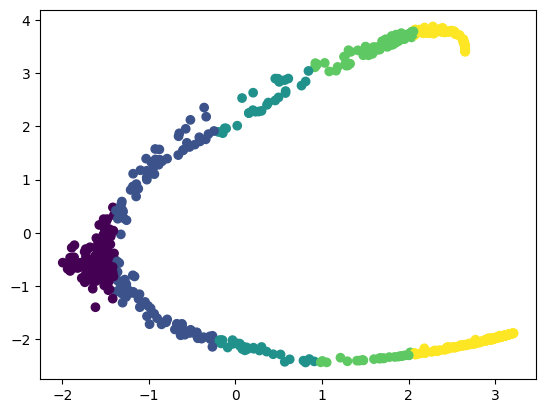

In [4]:
import matplotlib.pyplot as plt
plt.scatter(df.iloc[:,1],df.iloc[:,2],c=df.iloc[:,0])

In [5]:
groups = sorted([g for g in df.samples.unique() if g != args.hold_out])
steps = generate_steps(groups)
optimizer = torch.optim.Adam(f_net.parameters())
opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

# # logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available()
# sample_with_replacement = opts['sample_with_replacement' ]
# apply_losses_in_time = opts['apply_losses_in_time']

    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [6]:
f_net=f_net.to(device)

In [7]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

156

In [8]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 0.7179, 0.4038, 0.6154, 1.9295], dtype=torch.float64)

In [9]:
sample_size = (df[df['samples']==0.0].values.shape[0],)

### Training with $\mathcal{L}_{\rm VGFM}$

In [10]:
f_net, v_losses, g_losses, losses = pretrain(
    f_net,
    df,
    optimizer,
    n_epoch=args.epochs1,
    hold_out=args.hold_out,
    logger=logger,
    relative_mass=relative_mass,
    reg=args.reg,
    reg_m=[args.reg_m, np.inf],
    norm_cost=args.norm_cost,
    batch_size=args.n_batch
)


relative_mass tensor([1.0000, 0.7179, 0.4038, 0.6154, 1.9295], dtype=torch.float64)
t_train: [0, 1, 2, 3, 4]


Begin flow and growth matching...: 100%|██████████| 500/500 [00:03<00:00, 153.16epoch/s, loss=0.030033, vloss=0.017668, gloss=0.012365]


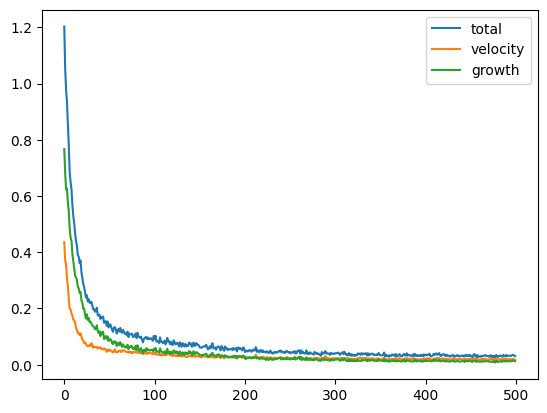

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses,label='total')
plt.plot(v_losses,label='velocity')
plt.plot(g_losses,label='growth')
plt.legend()

In [12]:
torch.save(f_net.state_dict(), os.path.join(exp_dir+'/pretrain_best_model'))

In [13]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/pretrain_best_model'),map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(f_net.parameters(),lr=args.learning_rate2)

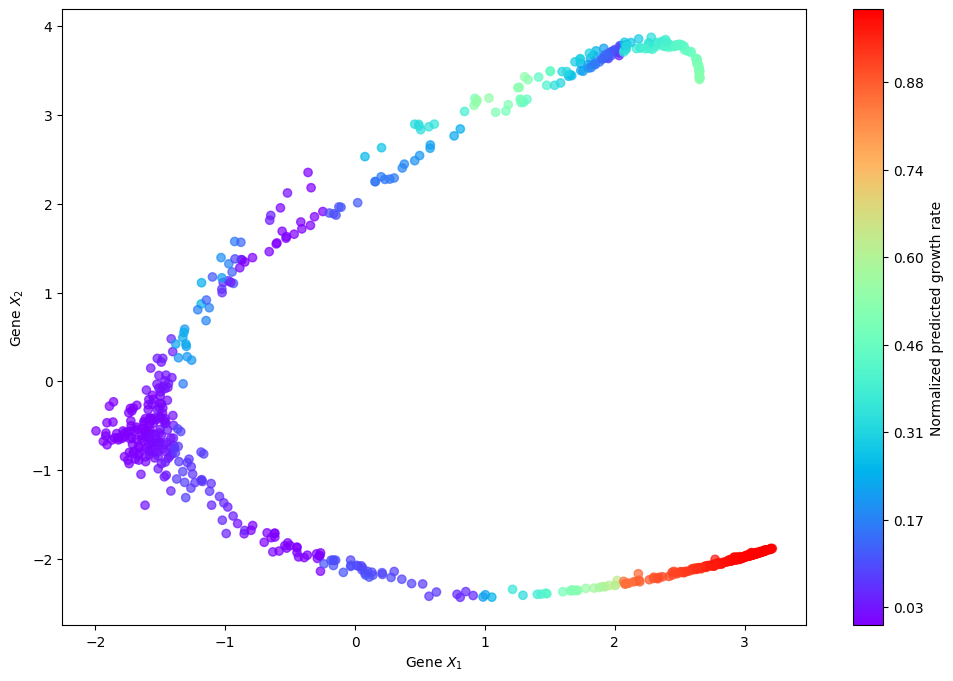

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 5

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pretrain.pdf')

In [15]:
# generate plot data
f_net.to('cpu')
generated, trajectories,_,_ = generate_plot_data(
    f_net, df, n_points=200, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3., 4.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])
<class 'torch.Tensor'>


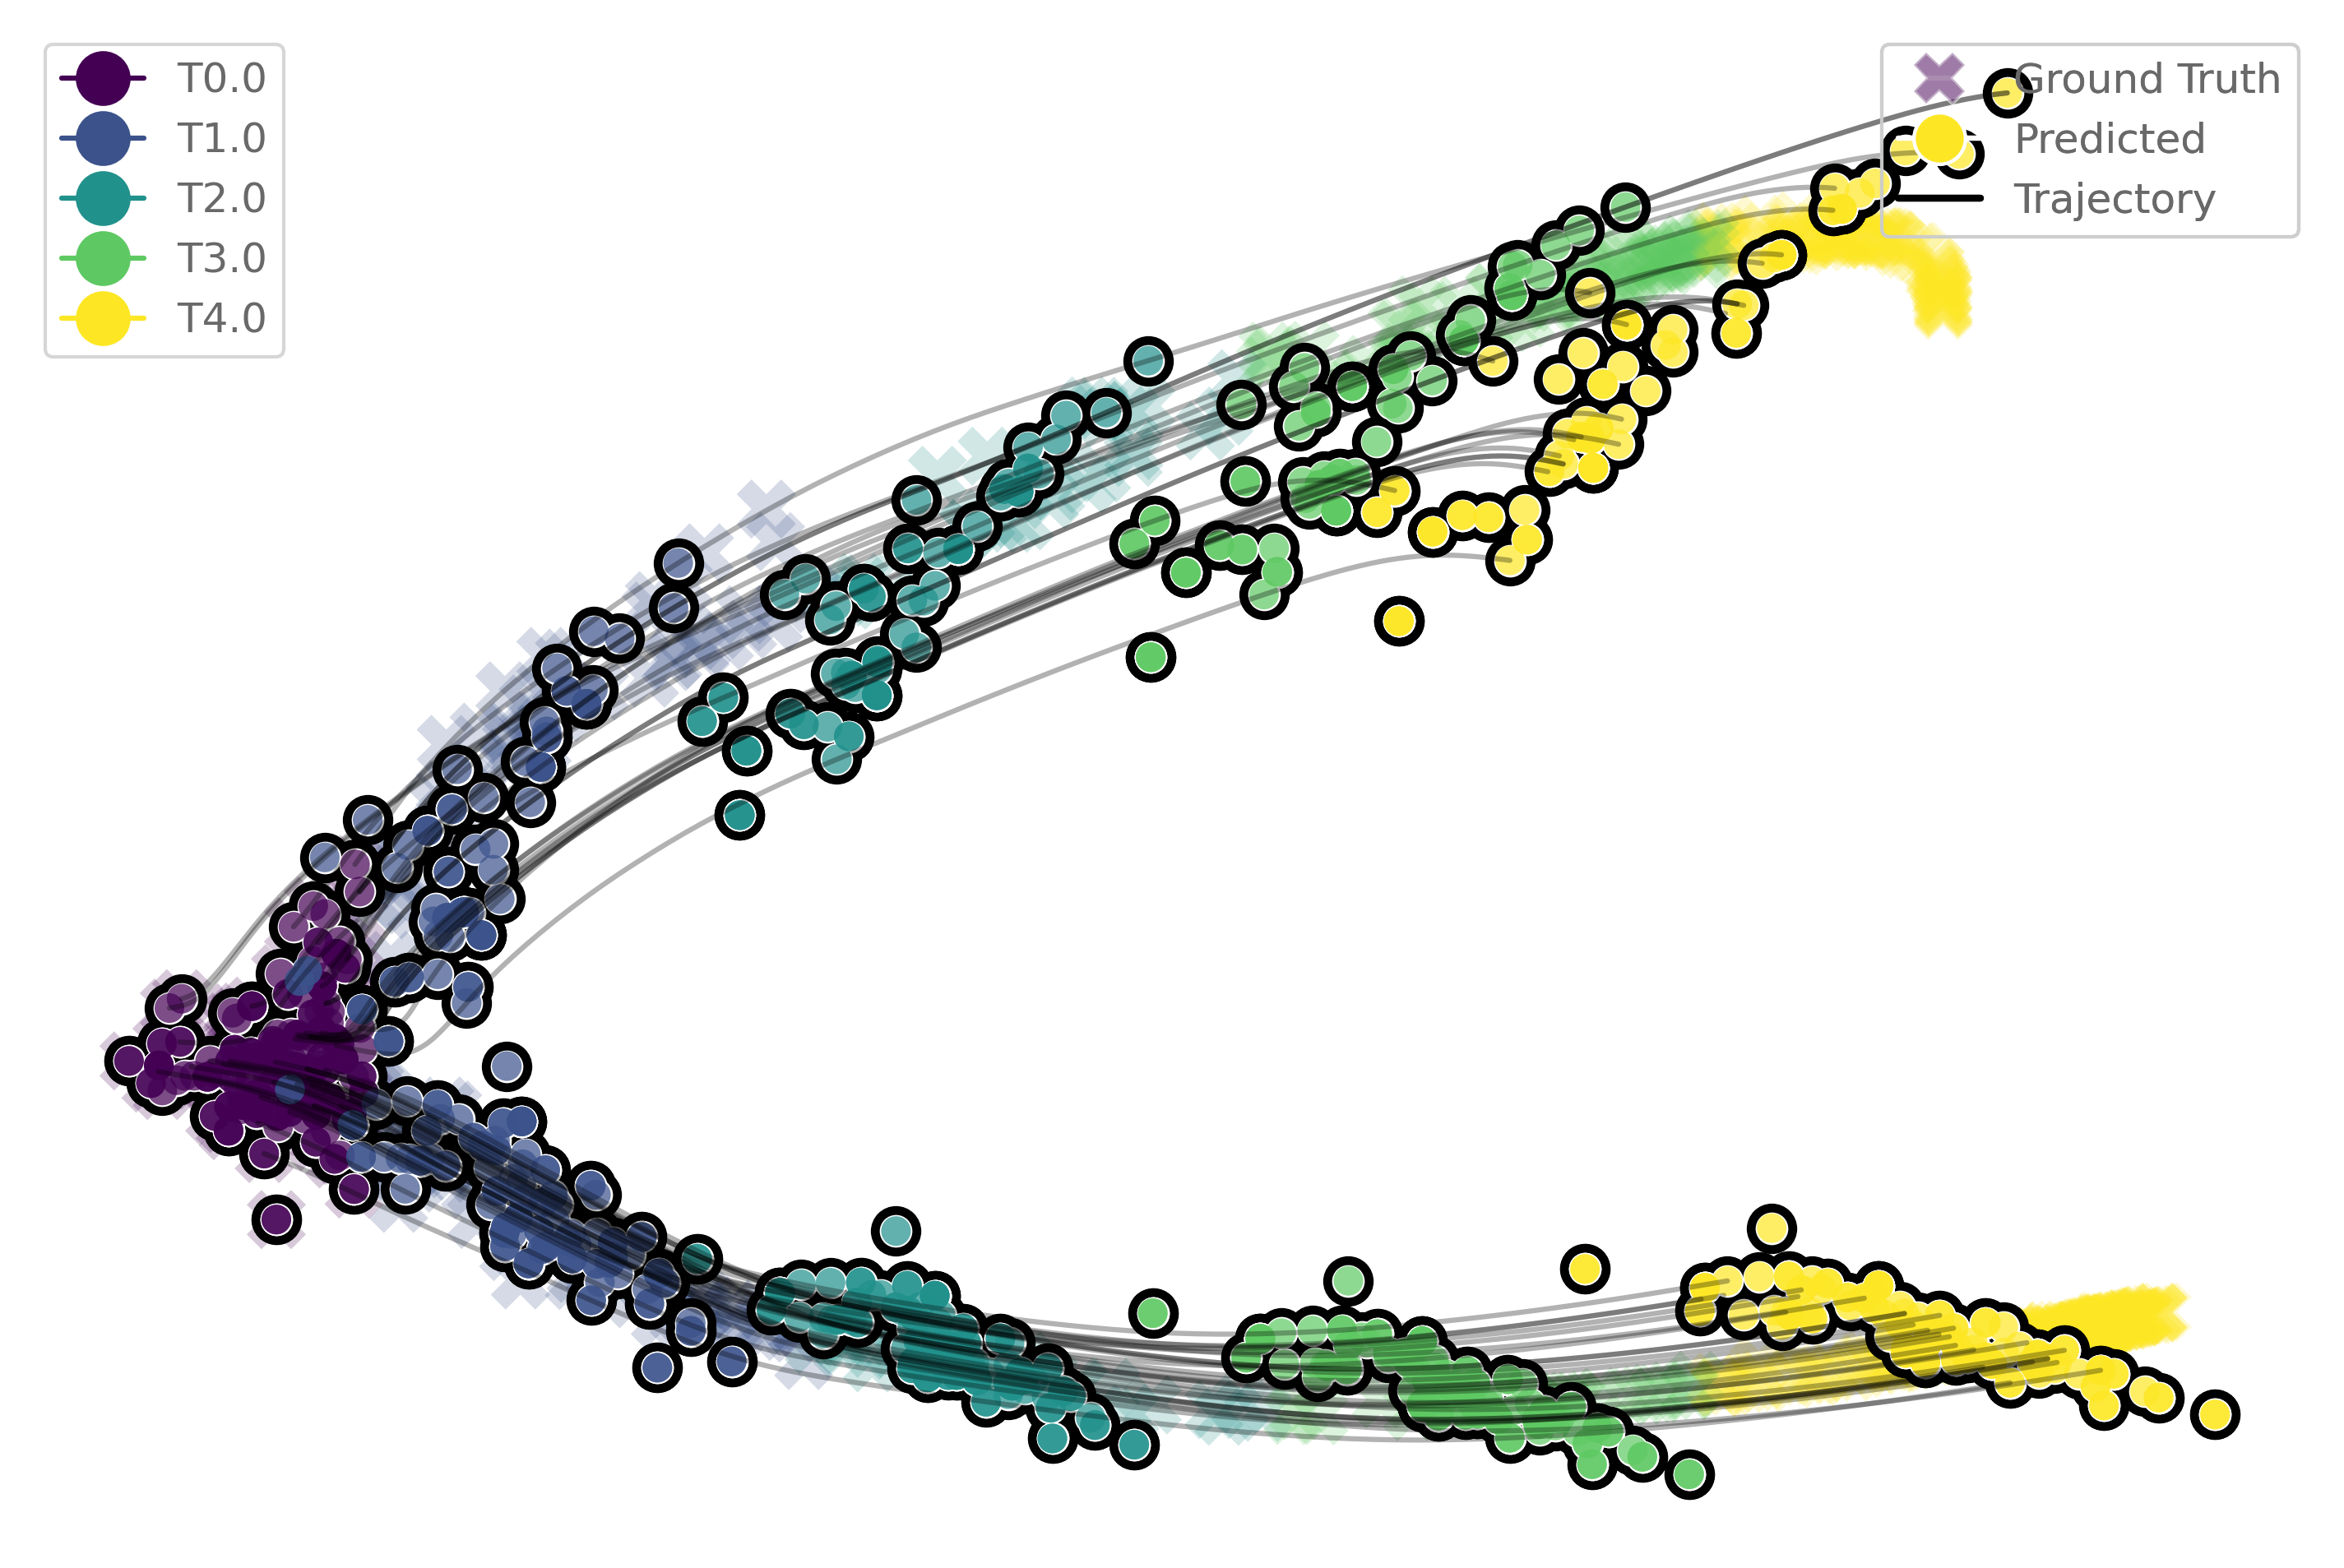

In [16]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_pretrain.png',
    x='x1', y='x2', is_3d=False
)

### Incorporating $\mathcal{L}_{\rm OT}$

In [17]:
logger.info("Incorporating $L_{ot}$")

# 训练阶段
l_loss, b_loss, g_loss = train(
    f_net,
    df,
    groups,
    optimizer,
    args.epochs2,  # n_epoch
    criterion=criterion,
    use_cuda=use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out,
    hold_out=args.hold_out,
    sample_size=sample_size,
    relative_mass=relative_mass,
    initial_size=initial_size,
    sample_with_replacement=args.sample_with_replacement,
    logger=logger,
    device=device,
    best_model_path=exp_dir + "/best_model",
    stepsize=0.1,
)

# 累积损失
for k, v in l_loss.items():
    local_losses[k].extend(v)

batch_losses.extend(b_loss)
globe_losses.extend(g_loss)


  0%|          | 0/30 [00:00<?, ?it/s]d:\NeurIPS_2025_VGFM\VGFM\notebooks\..\VGFM\train.py:200: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()
  3%|▎         | 1/30 [00:00<00:03,  8.44it/s]

epoch_0_0:
relative_mass_pred:0.6780165433883667,relative_mass_now:0.717948717948718
RME:0.05561981456620353
Otloss:0.637515
total loss:0.637515
epoch_0_1:
relative_mass_pred:0.3962934613227844,relative_mass_now:0.40384615384615385
RME:0.018701905295962398
Otloss:0.587716
total loss:0.587716
epoch_0_2:
relative_mass_pred:0.4620774984359741,relative_mass_now:0.6153846153846154
RME:0.2491240650415421
Otloss:1.2662
total loss:1.2662
epoch_0_3:
relative_mass_pred:1.5078644752502441,relative_mass_now:1.9294871794871795
RME:0.21851542146498976
Otloss:0.774912
total loss:0.774912
New minimum otloss found: 0.7749118804931641. Model saved.
epoch_1_0:
relative_mass_pred:0.6807847023010254,relative_mass_now:0.717948717948718
RME:0.05176416465214321
Otloss:0.556484
total loss:0.556484
epoch_1_1:
relative_mass_pred:0.39511838555336,relative_mass_now:0.40384615384615385
RME:0.02161161672501339
Otloss:0.46021
total loss:0.46021
epoch_1_2:
relative_mass_pred:0.5118625164031982,relative_mass_now:0.6153

 13%|█▎        | 4/30 [00:00<00:02,  9.67it/s]

New minimum otloss found: 0.717769205570221. Model saved.
epoch_2_0:
relative_mass_pred:0.6811337471008301,relative_mass_now:0.717948717948718
RME:0.05127799510955811
Otloss:0.50445
total loss:0.50445
epoch_2_1:
relative_mass_pred:0.39693301916122437,relative_mass_now:0.40384615384615385
RME:0.01711823826744445
Otloss:0.433333
total loss:0.433333
epoch_2_2:
relative_mass_pred:0.5412044525146484,relative_mass_now:0.6153846153846154
RME:0.12054276466369634
Otloss:0.847588
total loss:0.847588
epoch_2_3:
relative_mass_pred:1.9805119037628174,relative_mass_now:1.9294871794871795
RME:0.026444707598005008
Otloss:0.912439
total loss:0.912439
epoch_3_0:
relative_mass_pred:0.6805806159973145,relative_mass_now:0.717948717948718
RME:0.0520484277180263
Otloss:0.466108
total loss:0.466108
epoch_3_1:
relative_mass_pred:0.40033257007598877,relative_mass_now:0.40384615384615385
RME:0.008700302668980212
Otloss:0.389313
total loss:0.389313
epoch_3_2:
relative_mass_pred:0.5480177402496338,relative_mass_no

 20%|██        | 6/30 [00:00<00:02,  9.57it/s]

epoch_4_0:
relative_mass_pred:0.6808100342750549,relative_mass_now:0.717948717948718
RME:0.05172888083117349
Otloss:0.439368
total loss:0.439368
epoch_4_1:
relative_mass_pred:0.4034297466278076,relative_mass_now:0.40384615384615385
RME:0.0010311035882859215
Otloss:0.38001
total loss:0.38001
epoch_4_2:
relative_mass_pred:0.5498132109642029,relative_mass_now:0.6153846153846154
RME:0.10655353218317037
Otloss:0.93154
total loss:0.93154
epoch_4_3:
relative_mass_pred:2.035714864730835,relative_mass_now:1.9294871794871795
RME:0.055054880059834714
Otloss:0.929081
total loss:0.929081
epoch_5_0:
relative_mass_pred:0.6821515560150146,relative_mass_now:0.717948717948718
RME:0.04986033269337246
Otloss:0.416952
total loss:0.416952
epoch_5_1:
relative_mass_pred:0.40557536482810974,relative_mass_now:0.40384615384615385
RME:0.004281855764843147
Otloss:0.411127
total loss:0.411127
epoch_5_2:
relative_mass_pred:0.5559811592102051,relative_mass_now:0.6153846153846154
RME:0.0965306162834168
Otloss:0.81275


 23%|██▎       | 7/30 [00:00<00:02,  9.53it/s]

epoch_6_0:
relative_mass_pred:0.6832829713821411,relative_mass_now:0.717948717948718
RME:0.04828443271773202
Otloss:0.400775
total loss:0.400775
epoch_6_1:
relative_mass_pred:0.40740498900413513,relative_mass_now:0.40384615384615385
RME:0.008812353724525067
Otloss:0.420303
total loss:0.420303
epoch_6_2:
relative_mass_pred:0.5608285665512085,relative_mass_now:0.6153846153846154
RME:0.08865357935428625
Otloss:0.739567
total loss:0.739567
epoch_6_3:
relative_mass_pred:1.7941542863845825,relative_mass_now:1.9294871794871795
RME:0.07013930672426953
Otloss:0.622966
total loss:0.622966
New minimum otloss found: 0.6229656934738159. Model saved.
epoch_7_0:
relative_mass_pred:0.6837995648384094,relative_mass_now:0.717948717948718
RME:0.04756489183221545
Otloss:0.386503
total loss:0.386503
epoch_7_1:
relative_mass_pred:0.4098932445049286,relative_mass_now:0.40384615384615385
RME:0.01497374829791839
Otloss:0.395405
total loss:0.395405
epoch_7_2:
relative_mass_pred:0.5614087581634521,relative_mass_

 27%|██▋       | 8/30 [00:00<00:02,  8.91it/s]

epoch_7_3:
relative_mass_pred:1.7888120412826538,relative_mass_now:1.9294871794871795
RME:0.07290804504952163
Otloss:0.582783
total loss:0.582783
New minimum otloss found: 0.5827834606170654. Model saved.
epoch_8_0:
relative_mass_pred:0.684536337852478,relative_mass_now:0.717948717948718
RME:0.046538672276905606
Otloss:0.375092
total loss:0.375092
epoch_8_1:
relative_mass_pred:0.4115700125694275,relative_mass_now:0.40384615384615385
RME:0.019125745410010907
Otloss:0.388524
total loss:0.388524
epoch_8_2:
relative_mass_pred:0.5641399621963501,relative_mass_now:0.6153846153846154
RME:0.08327256143093115
Otloss:0.734135
total loss:0.734135
epoch_8_3:
relative_mass_pred:1.8012417554855347,relative_mass_now:1.9294871794871795
RME:0.06646606692444051
Otloss:0.563506
total loss:0.563506


 33%|███▎      | 10/30 [00:01<00:02,  7.59it/s]

New minimum otloss found: 0.5635064840316772. Model saved.
epoch_9_0:
relative_mass_pred:0.6855663061141968,relative_mass_now:0.717948717948718
RME:0.045104073626654494
Otloss:0.363863
total loss:0.363863
epoch_9_1:
relative_mass_pred:0.4126938581466675,relative_mass_now:0.40384615384615385
RME:0.021908601125081358
Otloss:0.405284
total loss:0.405284
epoch_9_2:
relative_mass_pred:0.5692624449729919,relative_mass_now:0.6153846153846154
RME:0.07494852691888815
Otloss:0.697921
total loss:0.697921
epoch_9_3:
relative_mass_pred:1.807196855545044,relative_mass_now:1.9294871794871795
RME:0.06337970277399717
Otloss:0.546017
total loss:0.546017
New minimum otloss found: 0.5460174083709717. Model saved.
epoch_10_0:
relative_mass_pred:0.68621826171875,relative_mass_now:0.717948717948718
RME:0.04419599260602679
Otloss:0.35383
total loss:0.35383
epoch_10_1:
relative_mass_pred:0.41423627734184265,relative_mass_now:0.40384615384615385
RME:0.025727924846467496
Otloss:0.408581
total loss:0.408581
epoch

 40%|████      | 12/30 [00:01<00:02,  8.57it/s]

New minimum otloss found: 0.5380641222000122. Model saved.
epoch_11_0:
relative_mass_pred:0.6864331960678101,relative_mass_now:0.717948717948718
RME:0.043896619762693136
Otloss:0.345119
total loss:0.345119
epoch_11_1:
relative_mass_pred:0.4163934886455536,relative_mass_now:0.40384615384615385
RME:0.031069590931846962
Otloss:0.396762
total loss:0.396762
epoch_11_2:
relative_mass_pred:0.5719475150108337,relative_mass_now:0.6153846153846154
RME:0.07058528810739523
Otloss:0.70208
total loss:0.70208
epoch_11_3:
relative_mass_pred:1.8692405223846436,relative_mass_now:1.9294871794871795
RME:0.03122418108968641
Otloss:0.545339
total loss:0.545339
epoch_12_0:
relative_mass_pred:0.6867160201072693,relative_mass_now:0.717948717948718
RME:0.04350268627916064
Otloss:0.337084
total loss:0.337084
epoch_12_1:
relative_mass_pred:0.41785764694213867,relative_mass_now:0.40384615384615385
RME:0.034695125761486215
Otloss:0.398827
total loss:0.398827
epoch_12_2:
relative_mass_pred:0.574114978313446,relative

 47%|████▋     | 14/30 [00:01<00:01,  9.04it/s]

epoch_13_0:
relative_mass_pred:0.6870731711387634,relative_mass_now:0.717948717948718
RME:0.04300522591386523
Otloss:0.329705
total loss:0.329705
epoch_13_1:
relative_mass_pred:0.41856837272644043,relative_mass_now:0.40384615384615385
RME:0.036455018179757236
Otloss:0.408917
total loss:0.408917
epoch_13_2:
relative_mass_pred:0.5771045684814453,relative_mass_now:0.6153846153846154
RME:0.06220507621765142
Otloss:0.684117
total loss:0.684117
epoch_13_3:
relative_mass_pred:1.9038851261138916,relative_mass_now:1.9294871794871795
RME:0.013268838293132607
Otloss:0.531962
total loss:0.531962
New minimum otloss found: 0.5319618582725525. Model saved.
epoch_14_0:
relative_mass_pred:0.6873418092727661,relative_mass_now:0.717948717948718
RME:0.04263105137007577
Otloss:0.323767
total loss:0.323767
epoch_14_1:
relative_mass_pred:0.4194123148918152,relative_mass_now:0.40384615384615385
RME:0.038544779732113774
Otloss:0.404987
total loss:0.404987
epoch_14_2:
relative_mass_pred:0.5781095027923584,relat

 53%|█████▎    | 16/30 [00:01<00:01,  9.36it/s]

relative_mass_pred:0.6878495812416077,relative_mass_now:0.717948717948718
RME:0.04192379755633218
Otloss:0.3193
total loss:0.3193
epoch_15_1:
relative_mass_pred:0.4201870560646057,relative_mass_now:0.40384615384615385
RME:0.040463186445690316
Otloss:0.397487
total loss:0.397487
epoch_15_2:
relative_mass_pred:0.5776017308235168,relative_mass_now:0.6153846153846154
RME:0.06139718741178518
Otloss:0.680971
total loss:0.680971
epoch_15_3:
relative_mass_pred:1.9053899049758911,relative_mass_now:1.9294871794871795
RME:0.012488952902860435
Otloss:0.528346
total loss:0.528346
New minimum otloss found: 0.5283458828926086. Model saved.
epoch_16_0:
relative_mass_pred:0.6886212825775146,relative_mass_now:0.717948717948718
RME:0.040848927838461745
Otloss:0.315791
total loss:0.315791
epoch_16_1:
relative_mass_pred:0.42079633474349976,relative_mass_now:0.40384615384615385
RME:0.04197187650771366
Otloss:0.394149
total loss:0.394149
epoch_16_2:
relative_mass_pred:0.5769123435020447,relative_mass_now:0.6

 60%|██████    | 18/30 [00:02<00:01,  9.66it/s]

epoch_17_1:
relative_mass_pred:0.4212622046470642,relative_mass_now:0.40384615384615385
RME:0.043125459126063734
Otloss:0.393786
total loss:0.393786
epoch_17_2:
relative_mass_pred:0.5768747925758362,relative_mass_now:0.6153846153846154
RME:0.06257846206426626
Otloss:0.658307
total loss:0.658307
epoch_17_3:
relative_mass_pred:1.8764183521270752,relative_mass_now:1.9294871794871795
RME:0.027504109861050743
Otloss:0.489696
total loss:0.489696
New minimum otloss found: 0.48969602584838867. Model saved.
epoch_18_0:
relative_mass_pred:0.689733624458313,relative_mass_now:0.717948717948718
RME:0.03929959450449263
Otloss:0.31011
total loss:0.31011
epoch_18_1:
relative_mass_pred:0.42188841104507446,relative_mass_now:0.40384615384615385
RME:0.04467606544494627
Otloss:0.383253
total loss:0.383253
epoch_18_2:
relative_mass_pred:0.5767241716384888,relative_mass_now:0.6153846153846154
RME:0.0628232210874558
Otloss:0.668234
total loss:0.668234
epoch_18_3:
relative_mass_pred:1.8989055156707764,relative

 67%|██████▋   | 20/30 [00:02<00:01,  9.90it/s]

epoch_19_2:
relative_mass_pred:0.5773160457611084,relative_mass_now:0.6153846153846154
RME:0.06186142563819891
Otloss:0.668093
total loss:0.668093
epoch_19_3:
relative_mass_pred:1.9158096313476562,relative_mass_now:1.9294871794871795
RME:0.007088696045732988
Otloss:0.522696
total loss:0.522696
epoch_20_0:
relative_mass_pred:0.6902693510055542,relative_mass_now:0.717948717948718
RME:0.03855340395654951
Otloss:0.304507
total loss:0.304507
epoch_20_1:
relative_mass_pred:0.4222434163093567,relative_mass_now:0.40384615384615385
RME:0.0455551260993594
Otloss:0.383038
total loss:0.383038
epoch_20_2:
relative_mass_pred:0.5774475336074829,relative_mass_now:0.6153846153846154
RME:0.061647757887840327
Otloss:0.662703
total loss:0.662703
epoch_20_3:
relative_mass_pred:1.9115241765975952,relative_mass_now:1.9294871794871795
RME:0.009309729072342694
Otloss:0.516814
total loss:0.516814
epoch_21_0:
relative_mass_pred:0.6905343532562256,relative_mass_now:0.717948717948718
RME:0.038184293678828654
Otlos

 77%|███████▋  | 23/30 [00:02<00:00,  9.97it/s]

epoch_21_3:
relative_mass_pred:1.8988088369369507,relative_mass_now:1.9294871794871795
RME:0.015899738996131885
Otloss:0.504569
total loss:0.504569
epoch_22_0:
relative_mass_pred:0.6908640265464783,relative_mass_now:0.717948717948718
RME:0.037725105881690986
Otloss:0.300554
total loss:0.300554
epoch_22_1:
relative_mass_pred:0.423042893409729,relative_mass_now:0.40384615384615385
RME:0.0475347836812337
Otloss:0.376664
total loss:0.376664
epoch_22_2:
relative_mass_pred:0.5775350332260132,relative_mass_now:0.6153846153846154
RME:0.06150557100772863
Otloss:0.653178
total loss:0.653178
epoch_22_3:
relative_mass_pred:1.8872663974761963,relative_mass_now:1.9294871794871795
RME:0.021881867088748782
Otloss:0.493138
total loss:0.493138
epoch_23_0:
relative_mass_pred:0.6910878419876099,relative_mass_now:0.717948717948718
RME:0.03741336294582912
Otloss:0.298636
total loss:0.298636
epoch_23_1:
relative_mass_pred:0.4231691360473633,relative_mass_now:0.40384615384615385
RME:0.047847384498232864
Otlos

 83%|████████▎ | 25/30 [00:02<00:00, 10.02it/s]

relative_mass_pred:1.894610047340393,relative_mass_now:1.9294871794871795
RME:0.018075855863450785
Otloss:0.49982
total loss:0.49982
epoch_24_0:
relative_mass_pred:0.6912977695465088,relative_mass_now:0.717948717948718
RME:0.03712096384593419
Otloss:0.296853
total loss:0.296853
epoch_24_1:
relative_mass_pred:0.4231016933917999,relative_mass_now:0.40384615384615385
RME:0.047680383636837895
Otloss:0.372198
total loss:0.372198
epoch_24_2:
relative_mass_pred:0.5780026912689209,relative_mass_now:0.6153846153846154
RME:0.060745626688003596
Otloss:0.65256
total loss:0.65256
epoch_24_3:
relative_mass_pred:1.8993926048278809,relative_mass_now:1.9294871794871795
RME:0.015597188195516911
Otloss:0.506072
total loss:0.506072
epoch_25_0:
relative_mass_pred:0.6914868354797363,relative_mass_now:0.717948717948718
RME:0.03685762201036726
Otloss:0.295406
total loss:0.295406
epoch_25_1:
relative_mass_pred:0.42333143949508667,relative_mass_now:0.40384615384615385
RME:0.048249278749738396
Otloss:0.36511
tot

 87%|████████▋ | 26/30 [00:02<00:00,  8.56it/s]

epoch_25_3:
relative_mass_pred:1.896692156791687,relative_mass_now:1.9294871794871795
RME:0.016996755948494452
Otloss:0.502746
total loss:0.502746
epoch_26_0:
relative_mass_pred:0.6917561292648315,relative_mass_now:0.717948717948718
RME:0.03648253423827035
Otloss:0.294021
total loss:0.294021
epoch_26_1:
relative_mass_pred:0.42336684465408325,relative_mass_now:0.40384615384615385
RME:0.04833694866725374
Otloss:0.36603
total loss:0.36603
epoch_26_2:
relative_mass_pred:0.5774951577186584,relative_mass_now:0.6153846153846154
RME:0.06157036870718008
Otloss:0.651842
total loss:0.651842
epoch_26_3:
relative_mass_pred:1.8873155117034912,relative_mass_now:1.9294871794871795
RME:0.021856412539054404
Otloss:0.488796
total loss:0.488796


 93%|█████████▎| 28/30 [00:03<00:00,  8.27it/s]

New minimum otloss found: 0.4887958765029907. Model saved.
epoch_27_0:
relative_mass_pred:0.6918395757675171,relative_mass_now:0.717948717948718
RME:0.03636630518095834
Otloss:0.292493
total loss:0.292493
epoch_27_1:
relative_mass_pred:0.42356550693511963,relative_mass_now:0.40384615384615385
RME:0.048828874315534294
Otloss:0.362471
total loss:0.362471
epoch_27_2:
relative_mass_pred:0.5787799954414368,relative_mass_now:0.6153846153846154
RME:0.05948250740766531
Otloss:0.651758
total loss:0.651758
epoch_27_3:
relative_mass_pred:1.8976950645446777,relative_mass_now:1.9294871794871795
RME:0.016476976515050756
Otloss:0.496599
total loss:0.496599
epoch_28_0:
relative_mass_pred:0.6919715404510498,relative_mass_now:0.717948717948718
RME:0.03618249722889492
Otloss:0.290799
total loss:0.290799
epoch_28_1:
relative_mass_pred:0.42322051525115967,relative_mass_now:0.40384615384615385
RME:0.04797460919334773
Otloss:0.368595
total loss:0.368595
epoch_28_2:
relative_mass_pred:0.5796740055084229,relat

100%|██████████| 30/30 [00:03<00:00,  8.94it/s]

epoch_29_0:
relative_mass_pred:0.6919091939926147,relative_mass_now:0.717948717948718
RME:0.03626933693885804
Otloss:0.289693
total loss:0.289693
epoch_29_1:
relative_mass_pred:0.4238356649875641,relative_mass_now:0.40384615384615385
RME:0.04949783711206343
Otloss:0.353529
total loss:0.353529
epoch_29_2:
relative_mass_pred:0.5782372951507568,relative_mass_now:0.6153846153846154
RME:0.0603643953800202
Otloss:0.660723
total loss:0.660723
epoch_29_3:
relative_mass_pred:1.9084242582321167,relative_mass_now:1.9294871794871795
RME:0.010916331281693685
Otloss:0.515645
total loss:0.515645


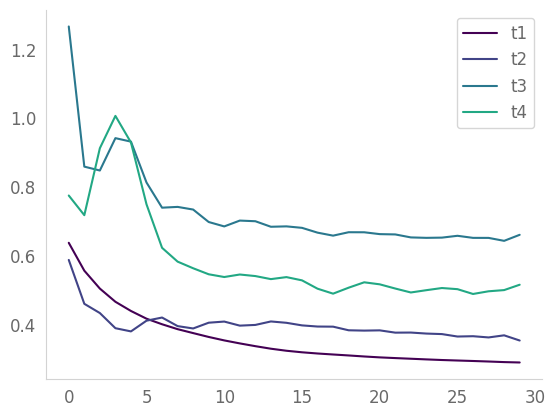

In [18]:
import os
import matplotlib.pyplot as plt

# 假设你已有变量：l_loss 和 exp_dir
plt.plot(l_loss['0.0:1.0'], label='t1')
plt.plot(l_loss['1.0:2.0'], label='t2')
plt.plot(l_loss['2.0:3.0'], label='t3')
plt.plot(l_loss['3.0:4.0'], label='t4')
plt.legend()

# 拼接保存路径
save_path = os.path.join(exp_dir, 'emd_train_each_tp.png')
plt.savefig(save_path)

### Test

In [19]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [20]:
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out, hold_out=args.hold_out, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

100%|██████████| 1/1 [00:00<00:00,  8.85it/s]

epoch_0_0:
relative_mass_pred:0.6918394565582275,relative_mass_now:0.717948717948718
RME:0.03636647122246879
Otloss:0.292493
total loss:0.292493
epoch_0_1:
relative_mass_pred:0.4234989583492279,relative_mass_now:0.40384615384615385
RME:0.04866408734094527
Otloss:0.362236
total loss:0.362236
epoch_0_2:
relative_mass_pred:0.5775269269943237,relative_mass_now:0.6153846153846154
RME:0.061518743634223993
Otloss:0.652783
total loss:0.652783
epoch_0_3:
relative_mass_pred:1.8856391906738281,relative_mass_now:1.9294871794871795
RME:0.022725203504594074
Otloss:0.488907
total loss:0.488907
New minimum otloss found: 0.4889072775840759. Model saved.


In [21]:
# generate plot data
f_net.to('cpu')
generated, trajectories,generated_weights,trajectories_weights = generate_plot_data(
    f_net, df, n_points=200, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3., 4.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0404, 0.0808, 0.1212, 0.1616, 0.2020, 0.2424, 0.2828, 0.3232,
        0.3636, 0.4040, 0.4444, 0.4848, 0.5253, 0.5657, 0.6061, 0.6465, 0.6869,
        0.7273, 0.7677, 0.8081, 0.8485, 0.8889, 0.9293, 0.9697, 1.0101, 1.0505,
        1.0909, 1.1313, 1.1717, 1.2121, 1.2525, 1.2929, 1.3333, 1.3737, 1.4141,
        1.4545, 1.4949, 1.5354, 1.5758, 1.6162, 1.6566, 1.6970, 1.7374, 1.7778,
        1.8182, 1.8586, 1.8990, 1.9394, 1.9798, 2.0202, 2.0606, 2.1010, 2.1414,
        2.1818, 2.2222, 2.2626, 2.3030, 2.3434, 2.3838, 2.4242, 2.4646, 2.5051,
        2.5455, 2.5859, 2.6263, 2.6667, 2.7071, 2.7475, 2.7879, 2.8283, 2.8687,
        2.9091, 2.9495, 2.9899, 3.0303, 3.0707, 3.1111, 3.1515, 3.1919, 3.2323,
        3.2727, 3.3131, 3.3535, 3.3939, 3.4343, 3.4747, 3.5152, 3.5556, 3.5960,
        3.6364, 3.6768, 3.7172, 3.7576, 3.7980, 3.8384, 3.8788, 3.9192, 3.9596,
        4.0000])
<class 'torch.Tensor'>


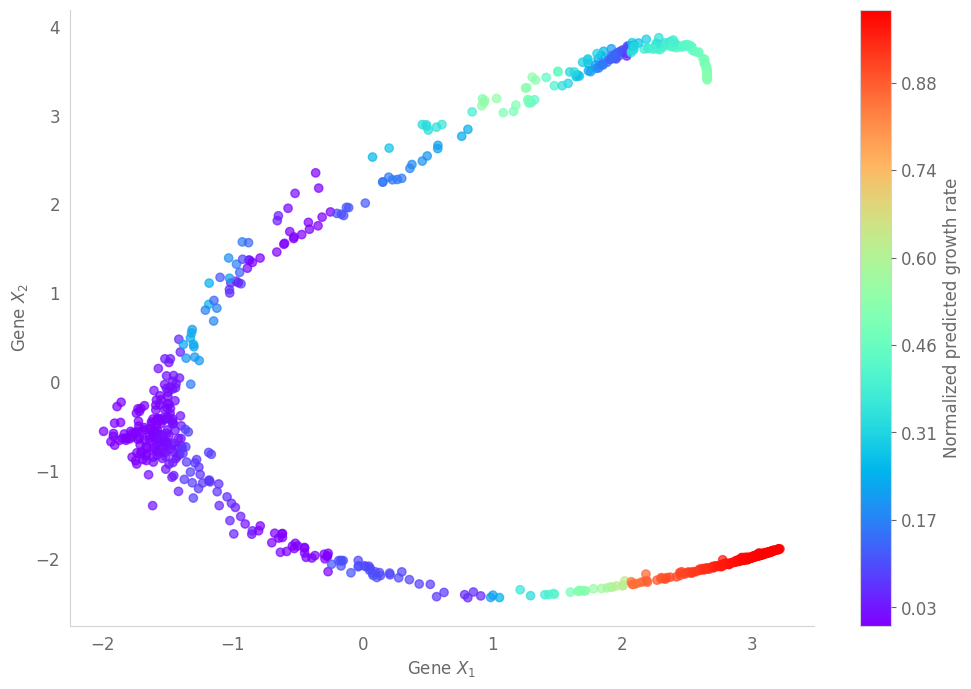

In [22]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 5

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_final.pdf')

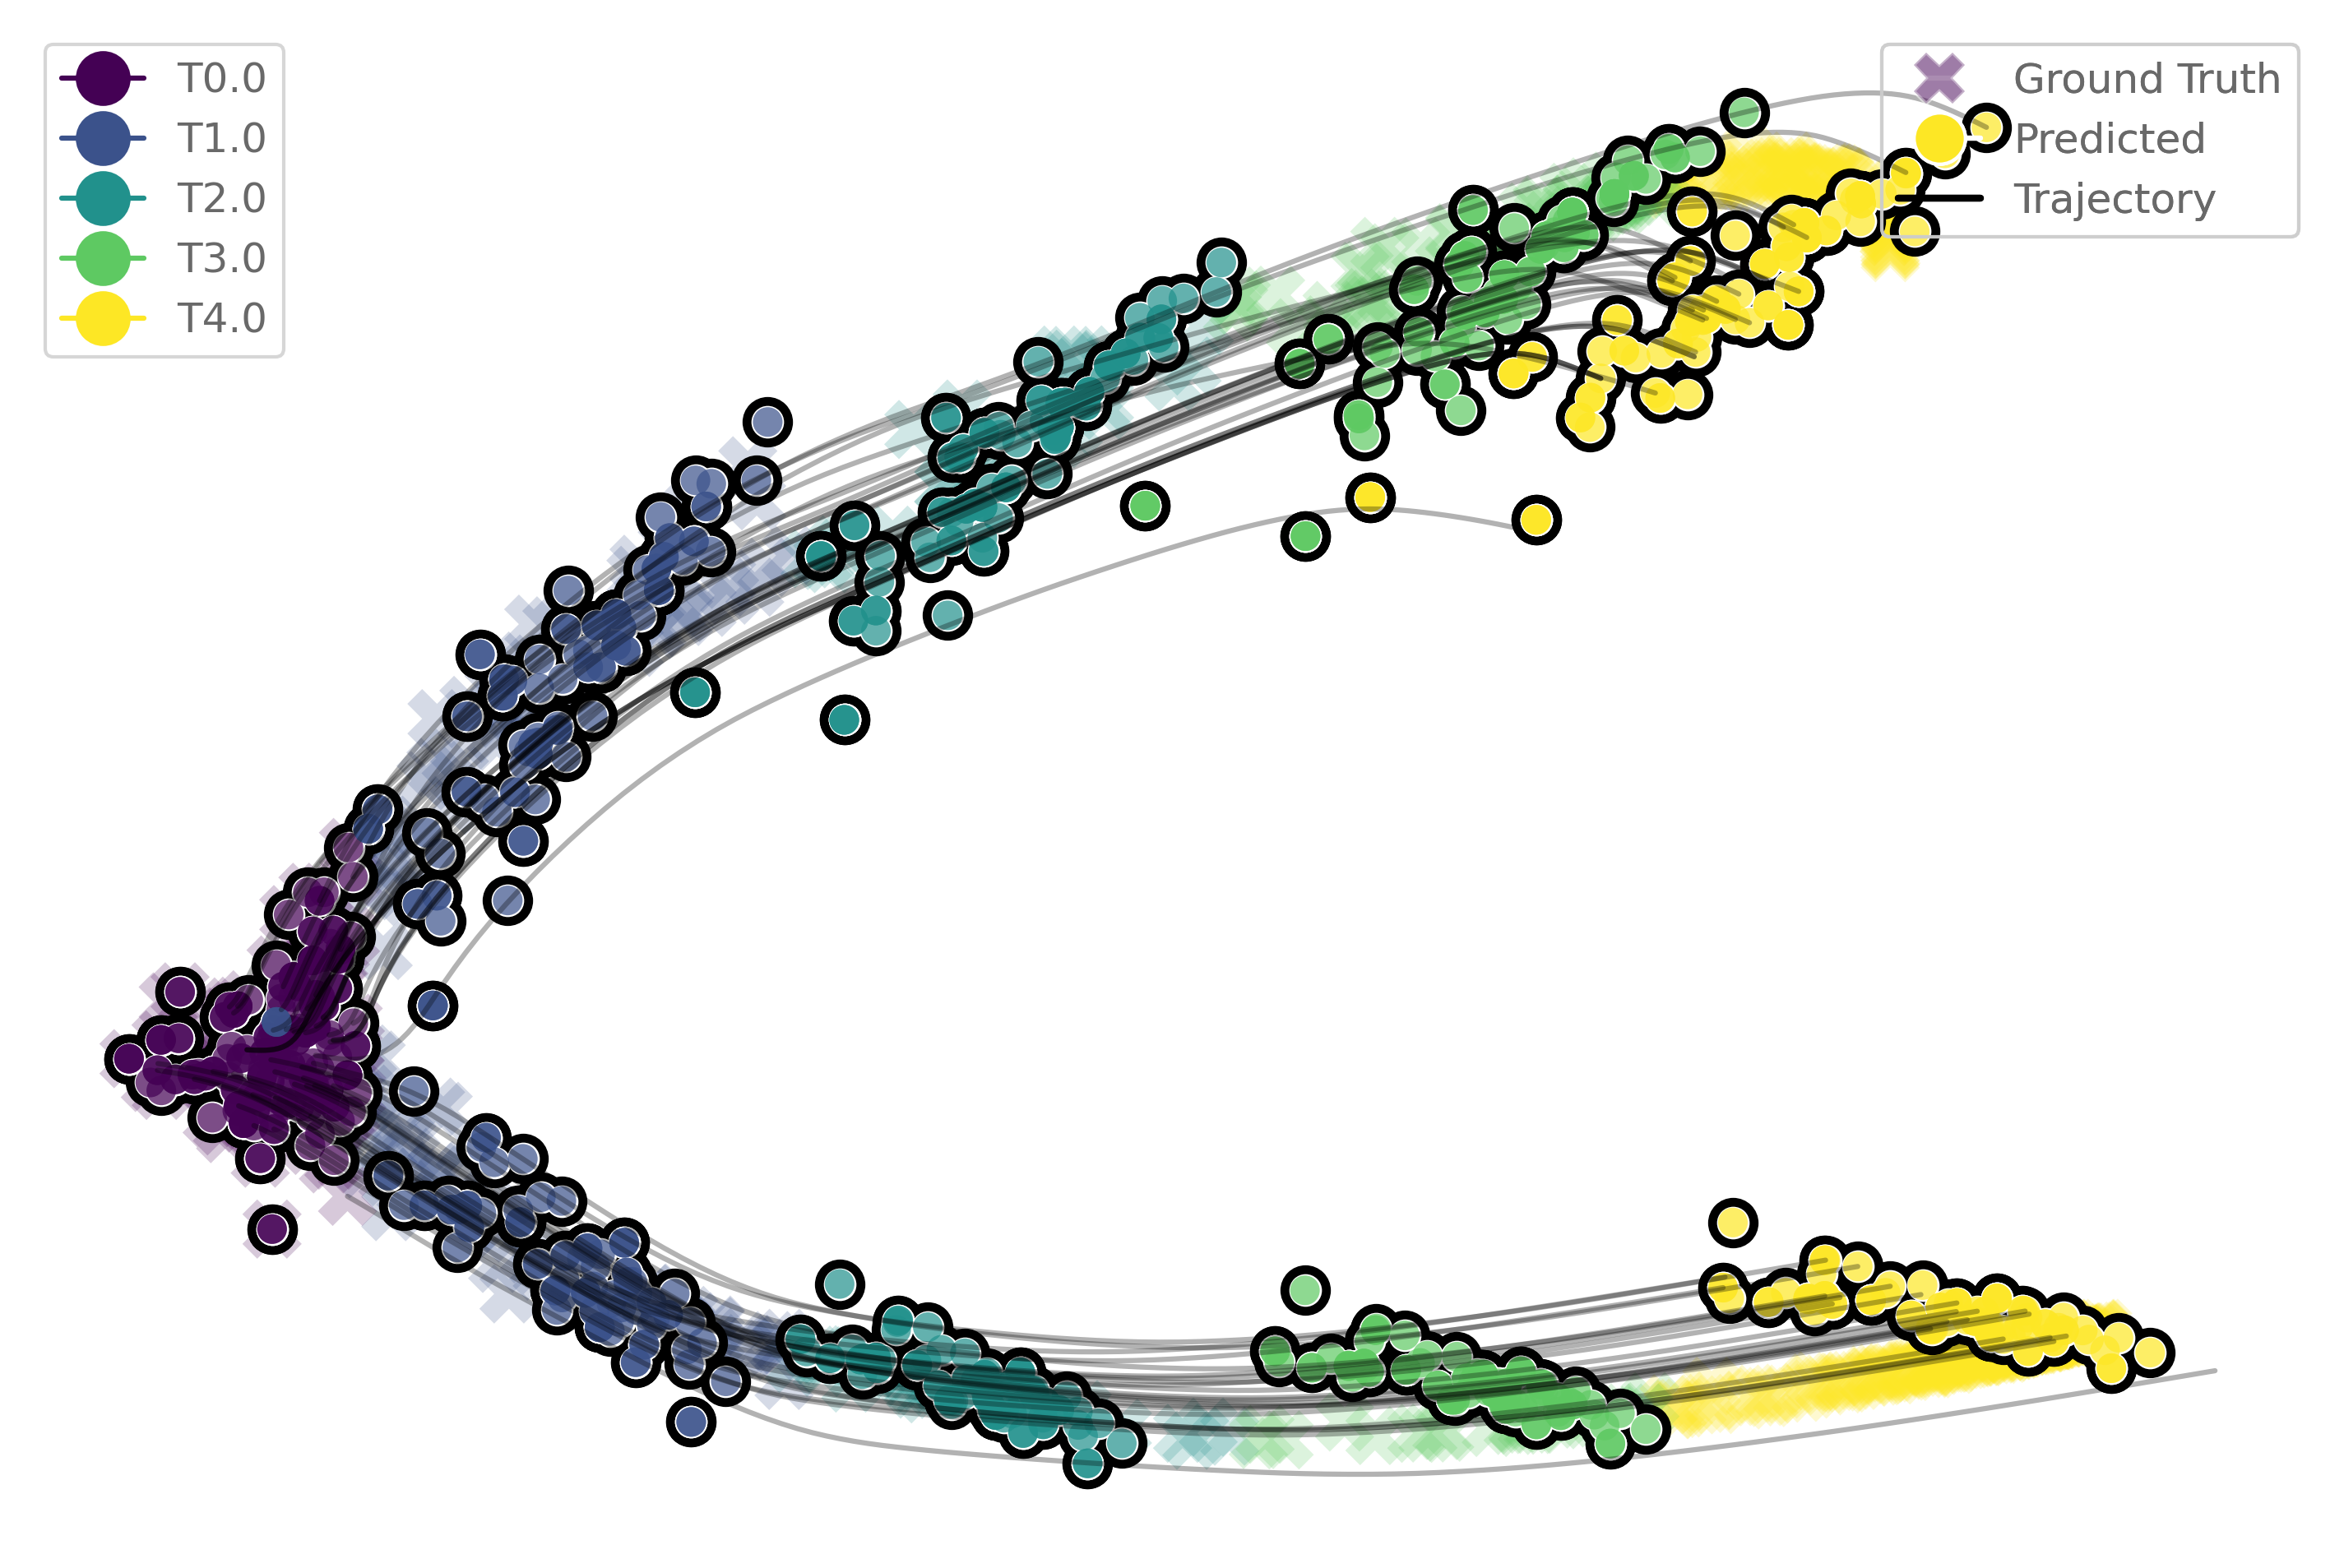

In [23]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_final.png',
    x='x1', y='x2', is_3d=False
)